In [1]:
import pandas as pd
import os
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy import stats


os.chdir("/home/gabri/Desktop/ADA/ADA_wikispeedia")
print(os.getcwd())

SAVE_FOLDER = "data_processed"

/home/gabri/Desktop/ADA/ADA_wikispeedia


## 1. **Transition Matrix Overview**
The **transition matrix** is a representation of how frequently users move from one article to another in a navigation path. The matrix shows transitions between articles and the probability of each transition.

### Transition Matrix Types:
- (**With Finished Paths:** Only includes transitions where the user reached a final goal or destination.) --> not used
- **With Both Finished and Unfinished Paths:** Includes all transitions, whether the user completed the journey or not.

### Objective:
- **Calculate Transition Frequency:** Determine how often each article is followed by another in all paths, providing a clear overview of user navigation.

## 2. **Shannon Entropy for a Single Article**
**Shannon Entropy** measures the unpredictability or randomness in user transitions from one article to others.

- If an article leads to many different next articles with roughly equal probabilities, the entropy will be high.
  
### High Entropy:
- **Indicates:** Users are transitioning from this article to many different articles without a clear dominant choice.
- **Possible Reasons:**
  - **Cognitive Load:** Users might be uncertain about which link to click next or are exploring multiple options.
  - **Unclear Navigation:** High-entropy areas may correspond to poor navigation design or overwhelming choices, leading to user confusion or cognitive overload.

### Implications of High Entropy:
- **Cognitive Overload:** Users may experience mental fatigue due to unclear paths.
- **Exploration vs. Confusion:** It may be an indicator of either natural exploration or poor design, depending on the context.


In [2]:
import numpy as np
import pandas as pd
import os

def calculate_entropy(transition_matrix):
    # Initialize entropy
    entropy = {}

    # Calculate entropy for each source article
    for source in transition_matrix.index:
        # Get the probabilities for transitions from this source
        probabilities = transition_matrix.loc[source]

        # Calculate entropy, treating zero probabilities as contributing zero
        entropy_value = 0
        for p in probabilities:
            if p > 0:  # Only calculate for non-zero probabilities
                entropy_value -= p * np.log2(p)  # Use log2 for bits

        # Store the entropy value for the source article
        entropy[source] = entropy_value

    return entropy

# Check if the transition matrix already exists
if not os.path.exists("data/entropy_data/transition_matrix.csv"):
    print("Creating transition Matrix (taking into account back-steps)...")

    # Read df with all the steps (both in finished and unfinished paths)
    df_links = pd.read_csv("data_processed/links_processed.csv")
    df_articles = pd.read_csv("data_processed/articles_processed.csv")

    # Create an empty transition matrix
    article_names = df_articles["article_id"]
    empty_matrix = pd.DataFrame(0, index=article_names, columns=article_names)

    # Count occurrences of transitions
    for i, row in df_links.iterrows():
        source = row["link_source_id"]
        target = row["link_target_id"]
        empty_matrix.loc[source, target] += 1

    # Step 3: Normalize to get probabilities
    row_sums = empty_matrix.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    transition_matrix = empty_matrix.div(row_sums, axis=0)

    # Display the transition matrix
    print("Transition Matrix:")
    print(transition_matrix)

    # Calculate the entropy for each article
    entropy_dict = calculate_entropy(transition_matrix)

    # Convert the entropy dictionary to a DataFrame for better visualization
    entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['article_id', 'entropy'])
    print("Entropy Values:")
    print(entropy_df)

    # Save to CSV if needed
    print("Saving matrix...")
    transition_matrix.to_csv("data/entropy_data/transition_matrix.csv")
    print("Saved matrix.")
else:
    transition_matrix = pd.read_csv("data/entropy_data/transition_matrix.csv", index_col=0)
    transition_matrix = transition_matrix.astype(float)  # Ensure the data type is float
    entropy_dict = calculate_entropy(transition_matrix)
    entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['article_id', 'entropy'])
    print("Entropy Values:")
    print(entropy_df)



Entropy Values:
      article_id   entropy
0              0  3.459432
1              1  4.247928
2              2  4.321928
3              3  3.000000
4              4  3.321928
...          ...       ...
4599        4599  6.209453
4600        4600  5.392317
4601        4601  4.807355
4602        4602  2.321928
4603        4603  3.906891

[4604 rows x 2 columns]


In [3]:
#checj for nan
missing_rows = transition_matrix[transition_matrix.isnull().any(axis=1)]
print(missing_rows.shape)
missing_rows

missing_rows = entropy_df[entropy_df.isnull().any(axis=1)]
print(missing_rows.shape)
missing_rows

(0, 4604)
(0, 2)


,article_id,entropy


## 3. **Path-Based Entropy Analysis**

### Average Entropy of a Path:
- For each transition in a user path, calculate the **entropy of the source article** and accumulate it for the entire path. This gives a sense of how predictable or unpredictable the navigation experience is for that user journey.

### Global Entropy for Finished and Unfinished Paths:
- **Finished Paths:** Calculate the average entropy for paths that are completed. A low entropy value suggests that users were consistently guided toward the end goal.
- **Unfinished Paths:** Calculate the average entropy for paths that are abandoned. A high entropy value suggests that users might have experienced confusion or cognitive overload, leading them to abandon the navigation.

In [4]:
df_paths = pd.read_csv("data_processed/all_articles_processed.csv")
#display(df_paths)

#dict that map each srticle to the relative entripy
mapping_dict_entropy = pd.Series(entropy_df.entropy.values, index=entropy_df.article_id).to_dict()

#print(mapping_dict_entropy)

mean_entropies_path = []
for i, row in df_paths.iterrows():
    resolved_path_list_id = ast.literal_eval(row["resolved_path_list_id"])
    #print(resolved_path_list_id)
    if row["finished"] == True:
        # remove last elements (there is NO uncertaly after, the game is finsihed)
        resolved_path_list_id = resolved_path_list_id[:-1]
    #print(resolved_path_list_id)
    path_entropies = [mapping_dict_entropy[item] for item in resolved_path_list_id]  
    #print(path_entropies)
    mean_entropy = np.mean(path_entropies)
    if mean_entropy == None:
        print(i) 
    mean_entropies_path.append(mean_entropy)
    #print(f"{i}/{df_paths.shape[0]} --> {100*i/df_paths.shape[0]:.2f}%")


df_paths["entropy_path"] = mean_entropies_path

df_paths.head(3)


/tmp/ipykernel_45461/2897264773.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("data_processed/all_articles_processed.csv")
/home/gabri/mambaforge/envs/ada/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabri/mambaforge/envs/ada/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,entropy_path
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]",5.998744
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]",6.463245
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,8,0,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]",6.249896


## 4. **Visual Analysis with Graphs and T-test**
- **Transition Matrix Graphs:** Visualize the transition probabilities between articles to easily spot high-frequency paths and anomalies.

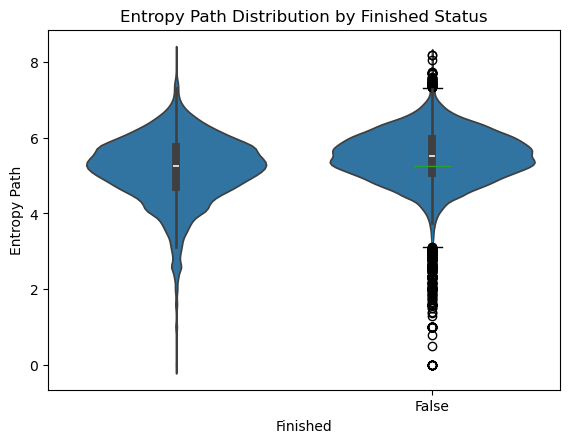

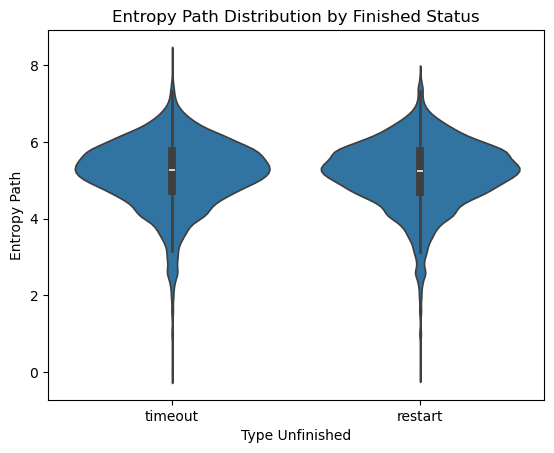

0.06026006920706253


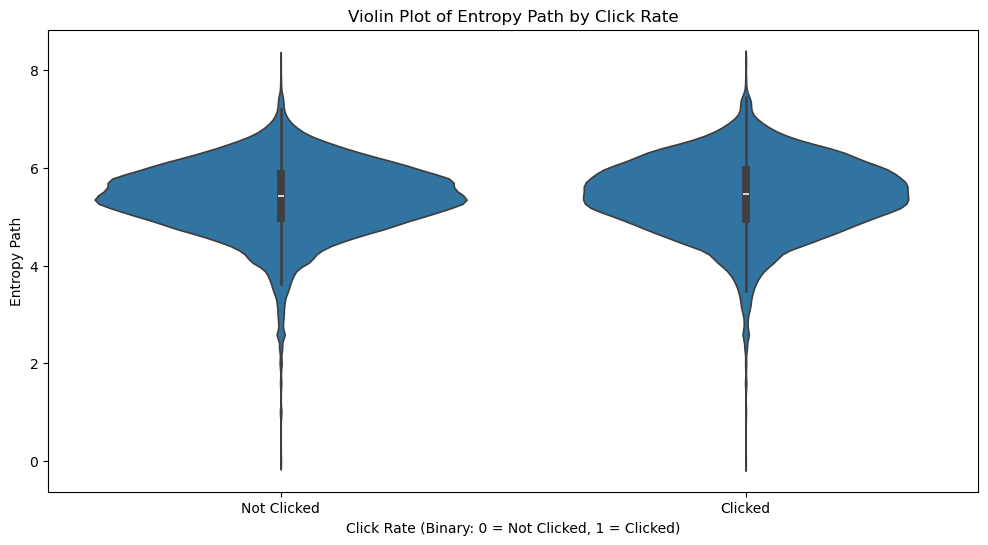

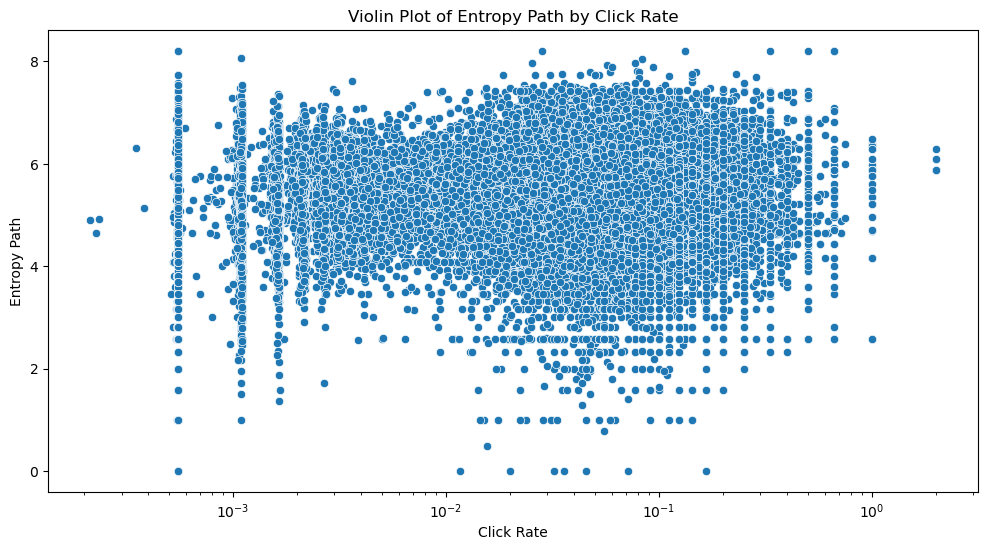

/tmp/ipykernel_45461/2565424188.py:47: RuntimeWarning: divide by zero encountered in log
  df_paths["log_click_rate"] = np.log(df_paths["click_rate"].values)


<Figure size 1200x600 with 0 Axes>

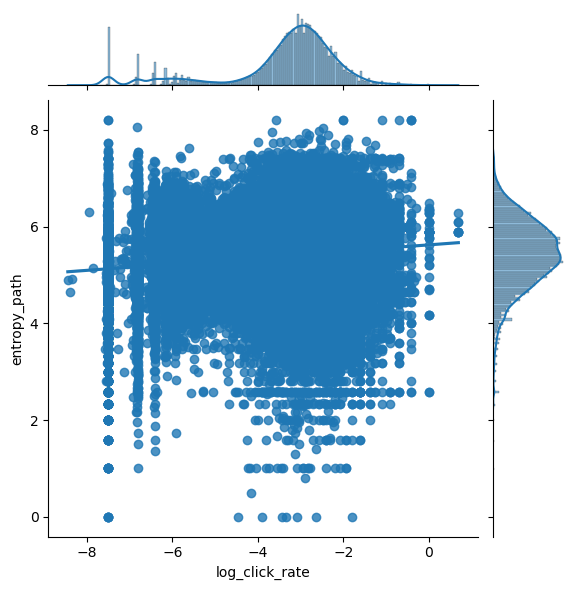

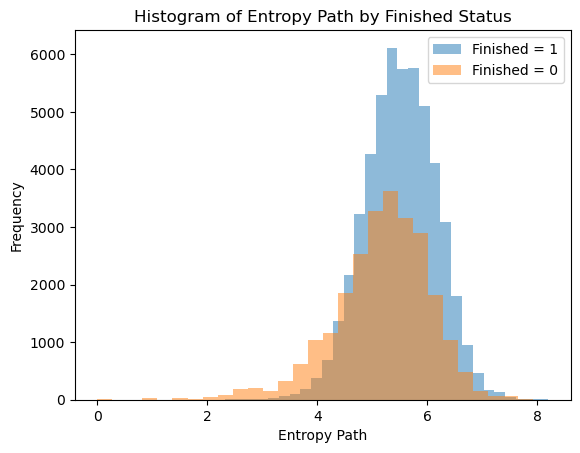

In [16]:

# Create the box plot
df_paths.boxplot(column="entropy_path", by="finished", grid=False)
plt.title('Box plot of Entropy Path by Finished Status')
plt.suptitle('')  # Suppress the default title to avoid duplication
plt.xlabel('Finished')
plt.ylabel('Entropy Path')

import seaborn as sns

# Violin plot: entropy Vs Finished/Unfinished Paths
sns.violinplot(x='finished', y='entropy_path', data=df_paths)
plt.title('Entropy Path Distribution by Finished Status')
plt.xlabel('Finished')
plt.ylabel('Entropy Path')
plt.show()

# Violin plot: entropy Vs Type Unfinished Paths
sns.violinplot(x='type_unfinished', y='entropy_path', data=df_paths[df_paths["finished"] == False])
plt.title('Entropy Path Distribution by Finished Status')
plt.xlabel('Type Unfinished')
plt.ylabel('Entropy Path')
plt.show()

# Violin plot: entropy Vs if the clickrate overcome a threshold Paths
# Define a threshold for click_rate (you can use mean or median)
threshold = df_paths['click_rate'].mean()
print(threshold)
df_paths['click_rate_binary'] = (df_paths['click_rate'] > threshold).astype(int)
plt.figure(figsize=(12, 6))
sns.violinplot(x='click_rate_binary', y='entropy_path', data=df_paths)
plt.xlabel('Click Rate (Binary: 0 = Not Clicked, 1 = Clicked)')
plt.ylabel('Entropy Path')
plt.title('Violin Plot of Entropy Path by Click Rate')
plt.xticks([0, 1], ['Not Clicked', 'Clicked'])
plt.show()

# Violin plot: entropy Vs clickrate
plt.figure(figsize=(12, 6))
sns.scatterplot(x='click_rate', y='entropy_path', data=df_paths)
plt.xlabel('Click Rate')
plt.ylabel('Entropy Path')
plt.title('Violin Plot of Entropy Path by Click Rate')
plt.xscale("log")
plt.show()

plt.figure(figsize=(12, 6))
df_paths["log_click_rate"] = np.log(df_paths["click_rate"].values)
sns.jointplot(data = df_paths, x = 'log_click_rate', y = 'entropy_path', kind="reg")
plt.show()

# Histogram
plt.hist(df_paths[df_paths['finished'] == 1]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 1')
plt.hist(df_paths[df_paths['finished'] == 0]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 0')
plt.title('Histogram of Entropy Path by Finished Status')
plt.xlabel('Entropy Path')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [17]:
# Check if 'entropy_path' and 'finished' columns exist and have valid data
if 'entropy_path' in df_paths.columns and 'finished' in df_paths.columns:
    # Separate the groups based on the 'finished' column
    group1 = df_paths[df_paths['finished'] == 1]['entropy_path'].dropna()  # Group where finished = 1
    group2 = df_paths[df_paths['finished'] == 0]['entropy_path'].dropna()  # Group where finished = 0

    # Perform an independent t-test
    # ATTENTION: from the hist of above the data seems gaussian
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)  # Use equal_var=False for Welch's t-test

    # Print the results
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    # Interpret the p-value
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Reject the null hypothesis: The means are significantly different.")
    else:
        print("Fail to reject the null hypothesis: The means are not significantly different.")
else:
    print("Required columns are missing from the DataFrame.")

T-statistic: 60.22775649675074
P-value: 0.0
Reject the null hypothesis: The means are significantly different.


# 5. Entropy of single articles: Degree (connectivity analysis)

In [7]:
entropy_df
df_articles = pd.read_csv("data_processed/articles_processed.csv")
entropy_df = pd.merge(entropy_df,df_articles)
entropy_df


,article_id,entropy,article_name
0,0,3.459432,Áedán mac Gabráin
1,1,4.247928,Åland
2,2,4.321928,Édouard Manet
3,3,3.000000,Éire
4,4,3.321928,Óengus I of the Picts
...,...,...,...
4599,4599,6.209453,Zionism
4600,4600,5.392317,Zirconium
4601,4601,4.807355,Zoroaster
4602,4602,2.321928,Zuid-Gelders


<Axes: ylabel='Frequency'>

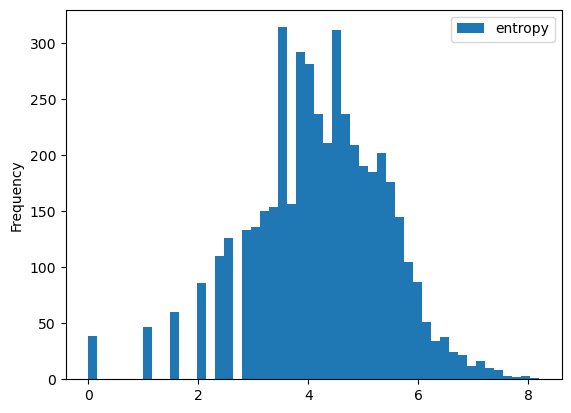

In [8]:
entropy_df.plot.hist(y="entropy", bins =50)

In [9]:
entropy_df.sort_values("entropy").tail(100)


,article_id,entropy,article_name
2908,2908,6.584963,NATO
3968,3968,6.584963,Sweden
4587,4587,6.584963,Zambia
1953,1953,6.599913,History of Earth
2424,2424,6.614710,Law
...,...,...,...
2515,2515,7.754888,List of sovereign states
2503,2503,7.882643,List of circulating currencies
2504,2504,7.930737,List of countries
1247,1247,7.994353,Driving on the left or right


- **Entropy Graphs:**
  - Highlight areas with high entropy to identify sections of the graph where users are most likely to experience cognitive overload.
  - **Finished vs Unfinished Path Entropy Comparison:** Compare the entropy distributions for finished and unfinished paths to detect problem areas in navigation.

# DISCUSSION

yes, finished paths have lower entropy --> so more cenrtaintly --> so less mental fatigue (the user is less loss)

But it seems that the nodes with higher entropy are also the one with higer conneticyty --> exapetd, we use highr concnetced node to move --  t more conencted nodes measn that i can go to more pages so this increse the entory f the page

SO let's now investigate the role of connectivity/centrality in relation to mental fatigue